# Distance maps with overlapping

In [1]:
import cv2
from fiberrandom import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import newaxis
from functions import *

In [78]:
canvas = np.zeros((256,256,3), np.uint8)
#print(canvas.shape)

sample = FiberSample(256,256,False)
waves = sample.createRandomWaves(10)
diameter = 5

for wave in waves:
    wave = np.array(wave).astype(int)
    wave = wave.reshape((-1,1,2))
    image = np.zeros((256,256,1), np.uint8)
    cv2.polylines(image,[wave],False,(255,255,255),diameter,cv2.LINE_AA)
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.distanceTransform(image,cv2.DIST_L2,3)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #image = image[:,:,newaxis]
    foreground = image[:,:]>0
    #print(foreground.shape)
    canvas[foreground] = image[foreground]


(256, 256, 3)


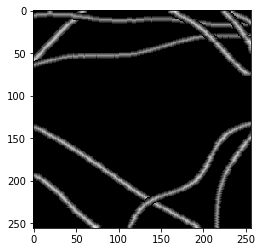

In [79]:
#canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
print(canvas.shape)
cv2.normalize(canvas, canvas, 0, 255, cv2.NORM_MINMAX)
plt.imshow(canvas, cmap='gray')
plt.show()

In [85]:
def TruncatedNormal(loc, scale, size, min_v, max_v):
    vec = np.random.normal(loc=loc, scale=scale, size=size)
    def f(val):
        if min_v > val:
            return True
        elif val > max_v:
            return True
        else:
            return False
    res = np.array(map(f, vec))
    if True in res:
        n_size = res.sum()
        vec[res] = TruncatedNormal(loc, scale, n_size, min_v, max_v)
    return vec

#col = TruncatedNormal(loc=127, scale=100, size=3, min_v=1, max_v=255)
#print(col)
def AddNoise(GT, mu, std, std_2, min_v, max_v):
    GT_lbl = label(GT)
    x, y = GT.shape
    GT_noise = np.zeros(shape=(x, y, 3))
    
    
    for i in range(1, GT_lbl.max() + 1):

        col = TruncatedNormal(loc=mu, scale=std, size=3, min_v=min_v, max_v=max_v)
        
        print('type col:', type(col))
        
        #GT_noise[GT_lbl == i] = col.astype(int)
        nrow = GT_lbl[GT_lbl == i].shape[0]
        
        print('nrow:', nrow)
        
        RANDOM = np.zeros(shape=(nrow, 3))
        
        print(f'random shape: {RANDOM.shape}')
        
        for j in range(3):
            RANDOM[:, j] = TruncatedNormal(loc=col[j], scale=std_2, size=nrow, min_v=min_v, max_v=max_v)
        
        GT_noise[GT_lbl == i] = RANDOM
        sys.exit(0)

    return GT_noise.astype('uint8')



def Noise(img, std):
    fl = img.flatten()
    vec = np.random.normal(loc=0, scale=std, size=len(fl))
    def g(val):
        if 0 > val:
            return -val
        else:
            return val
    #noise = np.array(map(g, vec))
    noise = list(map(g, vec))
    #noise = np.fromiter(noise, dtype=np.float64)
    noise = np.array(noise)
    #print(noise.shape)
    #print("*****", fl.shape, "***", vec.shape)
    res = fl + noise
    #res = fl + vec
    res = res.reshape(img.shape)
    res[res > 255.] = 255.
    return res.astype('uint8')

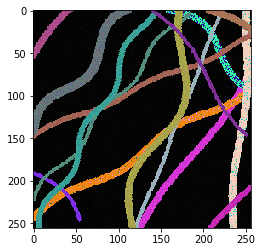

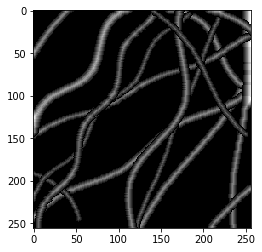

In [109]:
# images and masks (distance maps)

size = (256, 256, 3)

img = np.zeros(size, np.uint8)
dm = np.zeros(size, np.uint8)

sample = FiberSample(256,256,False)
fibers = randint(3,15)
waves = sample.createRandomWaves(fibers)
#diameter = 5

colors = randcolors(len(waves))

noise = np.zeros(shape=size, dtype=np.uint8)

for i,wave in enumerate(waves):
    diameter = randint(3, 10)
    wave = np.array(wave).astype(int)
    wave = wave.reshape((-1,1,2))
    image = np.zeros((256,256,1), np.uint8) #
    cv2.polylines(image,[wave],False,(255,255,255),diameter,cv2.LINE_AA)
    
    lbl = image.copy()
    
    image = cv2.distanceTransform(image,cv2.DIST_L2,3)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    foreground = image[:,:]>0
    dm[foreground] = image[foreground]
    
    # fibra de color
    #cv2.polylines(img, [wave], False, colors[i], diameter, cv2.LINE_8)
    
   
    #print(f'fg shape: {dm[:,:,dm>0].shape}')
    #print('fg shape:', foreground.shape)
    #lbl[lbl==255] = 1
    lbl = lbl.reshape(256,256)
    #print(lbl.shape)
    #img = AddNoise(lbl, mu=127, std=50, std_2=10, min_v=1, max_v=255)
    
    
    col = TruncatedNormal(loc=127, scale=100, size=3, min_v=1, max_v=255)
    #print('col.shape: ',col.shape)
    
    nrow = lbl[lbl==255].shape[0] # nro de pixeles a rellenar
    RANDOM = np.zeros(shape=(nrow, 3))
    
    #print(f'random shape: {RANDOM.shape}')
    
    for j in range(3):
        RANDOM[:, j] = TruncatedNormal(loc=col[j], scale=10, size=nrow, min_v=1, max_v=255)
    img[lbl==255] = RANDOM
    #noise = noise.astype('uint8')
    #break
    

#plt.figure(figsize=(15,15))
#plt.imshow(img)
plt.imshow(Noise(img, 5))
plt.show()

cv2.imwrite('_dm_img.png', img)
    
cv2.normalize(dm, dm, 0, 255, cv2.NORM_MINMAX)
plt.imshow(dm, cmap='gray')
plt.show()

In [2]:
# creando el dataset

sample = FiberSample(256,256,printout=False)
imgs_dir = 'data_dm_overlapping/images'
masks_dir = 'data_dm_overlapping/masks'
initDirectory(imgs_dir)
initDirectory(masks_dir)

for i in range(3000):
    sample.setFibers((3,15))
    sample.setDiameters((3,10))
    sample.createDistanceMapSample()
    sample.saveDistanceMapSample(imgs_dir, masks_dir, i)

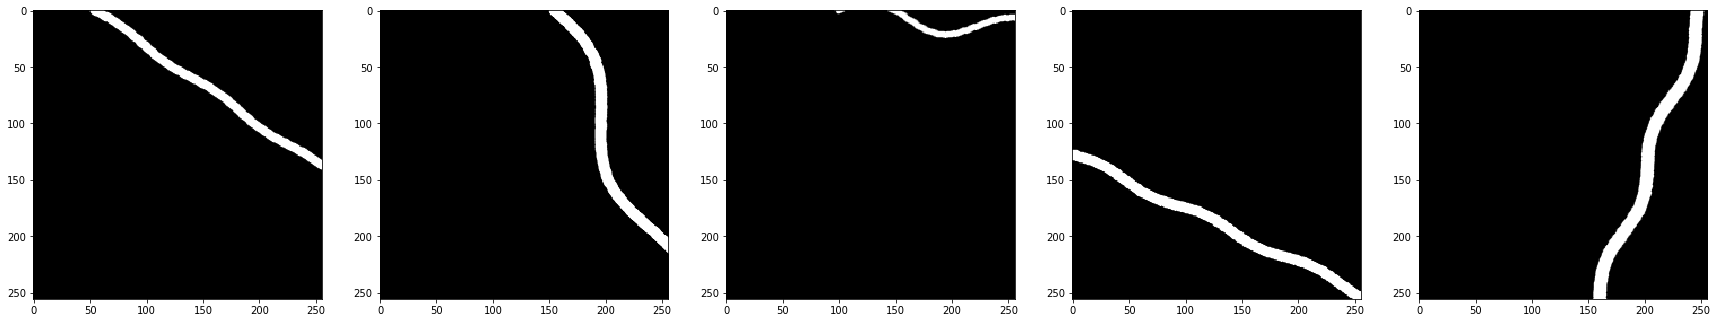

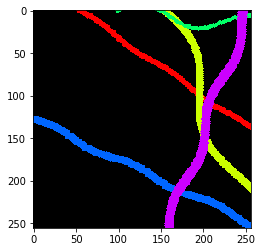

In [10]:
# segmentacion por partes a todo

size = (256, 256, 3)

img = np.zeros(size, np.uint8)
dm = np.zeros(size, np.uint8)

sample = FiberSample(256,256,False)
#fibers = randint(3,15)
fibers = 5
waves = sample.createRandomWaves(fibers)
#diameter = 5

colors = randcolors(len(waves))


plt.figure(figsize=(30,15))

for i,wave in enumerate(waves):
    diameter = randint(3, 10)
    wave = np.array(wave).astype(int)
    wave = wave.reshape((-1,1,2))
    
    #thickness = randint(fiber_thickness[0],fiber_thickness[1])
    cv2.polylines(img, [wave], False, colors[i], diameter, cv2.LINE_8)
    
    '''
    image = np.zeros((256,256,1), np.uint8)
    cv2.polylines(image,[wave],False,(255,255,255),diameter,cv2.LINE_AA)
    image = cv2.distanceTransform(image,cv2.DIST_L2,3)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    foreground = image[:,:]>0
    dm[foreground] = image[foreground]
    '''
    
    alone = np.zeros(size, np.uint8)
    cv2.polylines(alone,[wave], False, (255,255,255), diameter, cv2.LINE_AA)
    plt.subplot(1, fibers, i+1)
    plt.imshow(alone)
    
    
plt.show()

plt.imshow(img)
plt.show()

#cv2.imwrite('_dm_img.png', img)
    
#cv2.normalize(dm, dm, 0, 255, cv2.NORM_MINMAX)
#plt.imshow(dm, cmap='gray')
#plt.show()